# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 2: Ingeniería de características

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Horacio Martinez Alfaro  – Profesor Tutor

#### **Miembros del equipo:**
 - Jose Luis Artigas Arroyo - A01794906
 - José Luis Fabela Portillo - A00748551
 - Alejandro Emmanuel Silva Ortega - A01794545

In [2]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import re
from pfeature import pcp_wp
from pfeature import ctd_wp
from pfeature import sep_wp
from pfeature import rri_wp
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
#leer csv con dataset preprocesado
df_peptidos = pd.read_csv('../data/processed/peptide_processed2.csv')
df_peptidos.head(3).T

,0,1,2
Sequence,(RRWQWR)2-K-(Ahx),(RRWQWR)4-K2-(Ahx)2-C2,(XGLFGC)(XGLFGC)KGRKKRRQRRRPPQ
Binding_Target,NaN,NaN,Not available
Classification,NaN,NaN,TARGETED PEPTIDE CONJUGATES##MEMBRANE-TARGETED...
Activity,"ANTIMICROBIAL, ANTIBACTERIAL, ANTI-GRAM+, ANTI...","ANTIMICROBIAL, ANTIBACTERIAL, ANTI-GRAM+, ANTI...","ANTIMICROBIAL, ANTICANCER"
origen,DRAMP,DRAMP,DCTPep & DRAMP
DCTPep,0,0,0
DRAMP,0,0,1


### Eliminacion de columnas redundantes
Despues de un analis mas profundo, y una revision con el experto en el tema, se procedera a la eliminacion de columnas redundantes, ya que estos valores pueden ser obtenidos direcvtamente de la secuencia de peptidos, estas columnas son

- Chiral: Los aminoácidos L/D consisten en péptidos.
- Mass: Masa
- Formula: Formula del péptido
- Absent_amino_acids: Aminoacidos no incluidos
- Common_amino_acids: Animoacido mas comun en la sequencia
- pI: Punto isoeléctrico
- Basic_residues: Número de residuos base
- Acidic_residues: Número de residuos ácidos
- Net_charge: Carga Neta
- Polar_residues: Número de residuos polares
- Hydrophobic_residues: Número de residuos hidrofóbicos
- Hydrophobicity: Hidrofobicidad
- Boman_Index: Índice de Boman
- Half_Life: Vida media
- Aliphatic_Index: Índice alifático
- Extinction_Coefficient_cystines: Coeficiente de extinción de cistinas
- Absorbance_280nm: Absorbencia a 280nm


In [7]:
# drop_cols = ['Chiral','Mass','Formula','Absent_amino_acids','Common_amino_acids','pI','Basic_residues','Acidic_residues','Net_charge','Polar_residues','Hydrophobic_residues','Hydrophobicity','Boman_Index',
#              'Half_Life','Aliphatic_Index','Extinction_Coefficient_cystines','Absorbance_280nm']
# df_peptidos.drop(drop_cols, axis=1, inplace=True)

In [8]:
df_peptidos.head(5).T

,0,1,2,3,4
Sequence,(RRWQWR)2-K-(Ahx),(RRWQWR)4-K2-(Ahx)2-C2,(XGLFGC)(XGLFGC)KGRKKRRQRRRPPQ,AAAAAAARRRRΦFKX,AAAAARRRRΦFKX
Binding_Target,NaN,NaN,Not available,Not available,Not available
Classification,NaN,NaN,TARGETED PEPTIDE CONJUGATES##MEMBRANE-TARGETED...,CANCER TARGETED PEPTIDES##MEMBRANE-TARGETED##C...,CANCER TARGETED PEPTIDES##MEMBRANE-TARGETED##C...
Activity,"ANTIMICROBIAL, ANTIBACTERIAL, ANTI-GRAM+, ANTI...","ANTIMICROBIAL, ANTIBACTERIAL, ANTI-GRAM+, ANTI...","ANTIMICROBIAL, ANTICANCER","ANTIMICROBIAL, ANTICANCER","ANTIMICROBIAL, ANTICANCER"
origen,DRAMP,DRAMP,DCTPep & DRAMP,DCTPep & DRAMP,DCTPep & DRAMP
DCTPep,0,0,0,1,1
DRAMP,0,0,1,1,1


## Analisis de secuencias de péptidos

De acuerdo a la IUPAC[1], los aminoacidos se clasifican de acuerdo a la siguiente tabla


|symbol|Amino acid|
| :-:|:-:|
|A	| alanine|
|B	| aspartic acid or asparagine|
|C	| cysteine|
|D	| aspartic acid|
|E	| glutamic acid|
|F	| phenylalanine|
|G	| glycine|
|H	| histidine|
|I	| isoleucine|
|K	| lysine|
|L	| leucine|
|M	| methionine|
|N	| asparagine|
|P	| proline|
|Q	| glutamine|
|R	| arginine|
|S	| serine|
|T	| threonine|
|U  | selenocysteine|
|V	| valine|
|W	| tryptophan|
|X  | Desconocido u 'otro'|
|Y	| tyrosine|
|Z	| glutamic acid or glutamine|

Por lo cual, se eliminaran de la secuencia los caractares diferentes a los indicados en esta lista, de igual forma se actualizara la longitud de la secuencia para hacerla coincidir con la longitud despues de eliminar los caracteres invalidos, se eliminaran los registros con cadenas que contengan "-" y numeros (1-9) ya que estas representan peptidos modificados y contienen compuestos quimicos los cuales modifican el péptido y estos no seran considerados para el modelo.

In [9]:
df_peptidos#["Sequence"]

,Sequence,Binding_Target,Classification,Activity,origen,DCTPep,DRAMP
0,(RRWQWR)2-K-(Ahx),NaN,NaN,"ANTIMICROBIAL, ANTIBACTERIAL, ANTI-GRAM+, ANTI...",DRAMP,0,0
1,(RRWQWR)4-K2-(Ahx)2-C2,NaN,NaN,"ANTIMICROBIAL, ANTIBACTERIAL, ANTI-GRAM+, ANTI...",DRAMP,0,0
2,(XGLFGC)(XGLFGC)KGRKKRRQRRRPPQ,Not available,TARGETED PEPTIDE CONJUGATES##MEMBRANE-TARGETED...,"ANTIMICROBIAL, ANTICANCER",DCTPep & DRAMP,0,1
3,AAAAAAARRRRΦFKX,Not available,CANCER TARGETED PEPTIDES##MEMBRANE-TARGETED##C...,"ANTIMICROBIAL, ANTICANCER",DCTPep & DRAMP,1,1
4,AAAAARRRRΦFKX,Not available,CANCER TARGETED PEPTIDES##MEMBRANE-TARGETED##C...,"ANTIMICROBIAL, ANTICANCER",DCTPep & DRAMP,1,1
...,...,...,...,...,...,...,...
12724,yAIIXYNKYXNC,NaN,NaN,"ANTIMICROBIAL,ANTIVIRAL",DRAMP,0,0
12725,yf,Not available,TUMOR ACTIVE PEPTIDE,"ANTIMICROBIAL, ANTICANCER",DCTPep & DRAMP,1,1
12726,ykqchkkGGkkGsG,Not available,CANCER TARGETED PEPTIDES##MEMBRANE-TARGETED##C...,"ANTIMICROBIAL, ANTICANCER",DCTPep & DRAMP,1,1
12727,zV,Not available,TUMOR ACTIVE PEPTIDE,"ANTIMICROBIAL, ANTICANCER",DCTPep & DRAMP,1,1


In [10]:
df_peptidos["Sequence"].map(lambda x: re.sub(r"[\"]",'',x))

0                     (RRWQWR)2-K-(Ahx)
1                (RRWQWR)4-K2-(Ahx)2-C2
2        (XGLFGC)(XGLFGC)KGRKKRRQRRRPPQ
3                       AAAAAAARRRRΦFKX
4                         AAAAARRRRΦFKX
                      ...              
12724                      yAIIXYNKYXNC
12725                                yf
12726                    ykqchkkGGkkGsG
12727                                zV
12728                  ⓍKAPKVVⓍLSKALEYL
Name: Sequence, Length: 12729, dtype: object

In [11]:
# Crear un diccionario para contar la aparición de cada carácter de la secuencia de aminoácidos
char_count = {}

# Iterar sobre cada secuencia en la columna 'Sequence'
for sequence in df_peptidos['Sequence']:
    # Convertir la secuencia en un conjunto de caracteres únicos
    unique_chars = set(sequence)
    # Contar la aparición de cada carácter en el conjunto
    for char in unique_chars:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1

# Convertir el diccionario en un DataFrame para una mejor visualización
char_count_df = pd.DataFrame(list(char_count.items()), columns=['Character', 'Count'])
char_count_df['%'] = (char_count_df['Count'] / df_peptidos.shape[0]).round(4) *100

# Número de péptidos por caracter
char_count_df.T

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
Character,2,K,R,-,(,h,W,A,x,),...,q,d,工,u,b,j,],[,g,z
Count,3,9071,7214,26,6,11,5002,7895,87,6,...,21,8,1,1,1,3,1,1,29,1
%,0.02,71.26,56.67,0.2,0.05,0.09,39.3,62.02,0.68,0.05,...,0.16,0.06,0.01,0.01,0.01,0.02,0.01,0.01,0.23,0.01


Es importante identificar los caracteres contenidos en la secuencia de aminoácidos de los péptidos, por tal motivo vamos a analizar su ocurrencia en el total de péptidos. La lista utilizada es la que se describio anteriormente (IUPAC), sin embargo, para obtener las características con la librería de Pfeatures no se reconocen 4 de estos: B, U, X, Z. Asímismo existen otros caracteres no incluidos en IUPAC por lo que es necesario analizar que tan frecuentes son.

In [12]:
# Aminoácidos Pfeature
aa_pfeature = ['A','C','D','E','F','G','H','I','K','L','M','N','P',
              'Q','R','S','T','V','W','Y']

# Aminoácidos IUPAC - Pfeatures
aa_iupac = ['B','U','X','Z']

# Aminoácidos en minúsculas
aa_min = [elemento.lower() for elemento in (aa_pfeature + aa_iupac)]

print ('Total de aminoácidos IUPAC:', len(aa_iupac) + len(aa_pfeature))
print ('Total de aminoácidos Pfeatures:', len(aa_pfeature))
print ('Total de aminoácidos que están en UIPAC pero no reconoce Pfeatures:', len(aa_iupac))



Total de aminoácidos IUPAC: 24
Total de aminoácidos Pfeatures: 20
Total de aminoácidos que están en UIPAC pero no reconoce Pfeatures: 4


In [13]:
# Crear un diccionario para contar la aparición de cada carácter
char_count = {}

# Iterar sobre cada secuencia en la columna 'Sequence'
for sequence in df_peptidos['Sequence']:
    # Convertir la secuencia en un conjunto de caracteres únicos
    unique_chars = set(sequence)
    # Contar la aparición de cada carácter en el conjunto
    for char in unique_chars:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1

# Convertir el diccionario en un DataFrame para una mejor visualización
char_count_df = pd.DataFrame(list(char_count.items()), columns=['Character', 'Count'])
char_count_df['%'] = (char_count_df['Count'] / df_peptidos.shape[0]).round(4) *100


print('Total de caracteres únicos: ', len(char_count_df))

Total de caracteres únicos:  67


In [14]:
# Aminoácidos Pfeatures Mayúsculas
char_count_aapf = char_count_df[char_count_df['Character'].isin(aa_pfeature)]
print('Total de caracteres de Pfeatures incluidos en el dataset: ', len(char_count_aapf))
char_count_aapf.sort_values(by='Count', ascending=False).T

Total de caracteres de Pfeatures incluidos en el dataset:  20


,13,1,27,16,7,19,2,15,24,14,25,22,20,23,6,10,21,11,28,26
Character,L,K,I,G,A,V,R,F,S,P,N,T,E,D,W,Q,Y,C,H,M
Count,9541,9071,8101,7981,7895,7730,7214,7112,6597,5976,5772,5569,5054,5019,5002,4846,4813,4199,3387,3193
%,74.95,71.26,63.64,62.7,62.02,60.73,56.67,55.87,51.83,46.95,45.35,43.75,39.7,39.43,39.3,38.07,37.81,32.99,26.61,25.08


In [15]:
# Aminoácidos UIPAC no incluídos en Pfeatures Mayúsculas
char_count_aauipac = char_count_df[char_count_df['Character'].isin(aa_iupac)]
print('Total de caracteres de Pfeatures incluidos en el dataset: ', len(char_count_aauipac))
char_count_aauipac.sort_values(by='Count', ascending=False).T

Total de caracteres de Pfeatures incluidos en el dataset:  4


,17,50,29,55
Character,X,Z,B,U
Count,918,371,54,6
%,7.21,2.91,0.42,0.05


La ocurrencia de Z, B, U es muy baja por lo que se procederá a eliminar todos los péptidos que las contienen. 
Para el caso de los péptidos con 'x' se re-escribiran aquellas que solo tengan X al inicio o al final. Por ejemplo, si la secuencia es XXVKKGLISY reescribirla como VKKGLISY, si la secuencia es KKGLISYXXX entonces se reescribirá como KKGLISY. Sin embargo, si la secuencia es KKGXXLISY entonces se eliminará la secuencia del dataset.

In [16]:
# Aminoácidos UIPAC no incluídos en Pfeatures Mayúsculas
char_count_aamin = char_count_df[char_count_df['Character'].isin(aa_min)]
print('Total de caracteres de Pfeatures incluidos en el dataset: ', len(char_count_aamin))
char_count_aamin.sort_values(by='Count', ascending=False).T

Total de caracteres de Pfeatures incluidos en el dataset:  24


,30,35,34,32,38,8,44,43,41,37,...,42,56,39,57,51,5,58,60,61,66
Character,l,r,k,f,i,x,a,w,v,n,...,y,c,e,q,m,h,d,u,b,z
Count,180,179,156,103,87,87,77,76,61,54,...,28,28,21,21,14,11,8,1,1,1
%,1.41,1.41,1.23,0.81,0.68,0.68,0.6,0.6,0.48,0.42,...,0.22,0.22,0.16,0.16,0.11,0.09,0.06,0.01,0.01,0.01


La distincion entre los tipos de aminoácidos L o sinteticos y D o naturales se puede ver en estos resultados, siendo representados los tipo D con letras mayusculuas y los tipo L con minusculas. Gracias a este analisis podemos mostrar que no es relevante mantener la distincion entre estos aminoácidos y se hara un tratamiento a estos datos para convertir los caracteres en minusculas a mayusculas mas adelante.  

In [17]:
# Número de péptidos en los que está cada caracter que no es aminoácido IUPAC:
char_count_otros = char_count_df[~char_count_df['Character'].isin(aa_pfeature + aa_iupac + aa_min)]
print('Total de caracteres no incluidos en el UIPAC: ', len(char_count_otros))
char_count_otros.sort_values(by='Count', ascending=False).T

Total de caracteres no incluidos en el UIPAC:  19


,33,3,45,31,18,4,9,40,62,0,52,54,46,47,48,59,12,63,64
Character,Ⓧ,-,",",O,Φ,(,),,j,2,J,,6,1,7,工,4,],[
Count,236,26,18,18,11,6,6,5,3,3,2,2,1,1,1,1,1,1,1
%,1.85,0.2,0.14,0.14,0.09,0.05,0.05,0.04,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [18]:
char_count_otros['Character'].unique()

array(['2', '-', '(', ')', '4', 'Φ', 'O', 'Ⓧ', ' ', ',', '6', '1', '7',
       'J', '\xa0', '工', 'j', ']', '['], dtype=object)

La frecuencia de los caractéres no incluidos en IUPAC es muy baja, por lo que también se eliminarán los péptidos que las contienen.

In [19]:
# Ajuste de las secuencias de aminoácidos
filtered_df = df_peptidos.copy()
# 1. Poner en mayúsculas todos los aminoácidos de las secuencias
filtered_df['Sequence'] = filtered_df['Sequence'].str.upper()
# 2. Identificar los péptidos con valores de X
aa_x = filtered_df[filtered_df['Sequence'].apply(lambda x: 'X' in x)]
# 3. Conservar solo los péptidos que contengan los aminoácidos para pfeatures
filtered_df = filtered_df[filtered_df['Sequence'].apply(lambda x: all(char in aa_pfeature for char in x))]

In [20]:
# Identifica todos péptidos con valores de X
total_x = len(aa_x)
print('Total de péptidos con X', total_x)

# Inician con X 
inicio_x = aa_x[aa_x['Sequence'].str.startswith('X')]
print('Péptidos que empiezan con X: ', len(inicio_x))
# Función para quitar los caracteres 'x' al inicio de la secuencia
def quitar_x_inicio(secuencia):
    return re.sub(r'^X+', '', secuencia)
# Aplicar la función a la columna 'Sequence'
aa_x['Sequence'] = aa_x['Sequence'].apply(quitar_x_inicio)

# Finalizan con X
fin_x = aa_x[aa_x['Sequence'].str.endswith('X')].copy()
print('Péptidos que finalizan con X: ', len(fin_x))
# Función para quitar los caracteres 'x' al final de la secuencia
def quitar_x_final(secuencia):
    return re.sub(r'X+$', '', secuencia)
# Aplicar la función a la columna 'Sequence'
aa_x['Sequence'] = aa_x['Sequence'].apply(quitar_x_final)

# Elimina los péptidos con X intermedia
aa_x = aa_x[aa_x['Sequence'].apply(lambda x: all(char in aa_pfeature for char in x))]
print('Péptidos con X intermedia:', total_x - len(aa_x))
print('Peptidos conservados: ', len(aa_x))

Total de péptidos con X 960
Péptidos que empiezan con X:  280
Péptidos que finalizan con X:  232
Péptidos con X intermedia: 729
Peptidos conservados:  231


In [21]:
# Agrega los peptidos con X modificados al dataframe de péptidos depurados
filtered_df = pd.concat([filtered_df, aa_x], ignore_index=True)

print('Total de péptidos: ', df_peptidos.shape[0])
print('Péptidos solo con aminoácidos para pFeatures: ', filtered_df.shape[0])
print('Péptidos eliminados: ', round((df_peptidos.shape[0]-filtered_df.shape[0])/df_peptidos.shape[0],4) * 100, '%')

Total de péptidos:  12729
Péptidos solo con aminoácidos para pFeatures:  11318
Péptidos eliminados:  11.08 %


In [22]:
# Valida los aminoácidos contenidos
char_count = {}

# Iterar sobre cada secuencia en la columna 'Sequence'
for sequence in filtered_df['Sequence']:
    # Convertir la secuencia en un conjunto de caracteres únicos
    unique_chars = set(sequence)
    # Contar la aparición de cada carácter en el conjunto
    for char in unique_chars:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1

# Convertir el diccionario en un DataFrame para una mejor visualización
char_count_df = pd.DataFrame(list(char_count.items()), columns=['Character', 'Count'])
char_count_df['%'] = (char_count_df['Count'] / filtered_df.shape[0]).round(4) *100


print('Total de caracteres únicos: ', len(char_count_df))

Total de caracteres únicos:  20


In [23]:
filtered_df['DCTPep']

0        0
1        1
2        0
3        1
4        0
        ..
11313    1
11314    1
11315    1
11316    1
11317    1
Name: DCTPep, Length: 11318, dtype: int64

In [18]:
filtered_df.to_csv('../data/processed/peptide_filtered.csv', index = False)

### Convertir dataframe to FASTA 

Para los siguientes pasos del proceso, es necesario hacer la conversion de los datos filtrados a formato FASTA, este formato es el estandard usado para las secuencias de aminoácidos

In [24]:

with open('../data/processed/DCTPep.fasta','w', encoding='UTF8') as f:
    
    for _, row in filtered_df.iterrows():
        f.write(f">{row['DCTPep']}\n{row['Sequence']}\n")
    


### Ejecutar CD-HIT

CD-HIT es un programa ampliamente utilizado para agrupar secuencias biológicas con el fin de reducir la redundancia de secuencias y mejorar el rendimiento de otros análisis de secuencias. En respuesta al rápido aumento de la cantidad de datos de secuenciación producidos por las tecnologías de secuenciación de próxima generación, hemos desarrollado un nuevo programa CD-HIT acelerado con una novedosa estrategia de paralelización y algunas otras técnicas para permitir la agrupación eficiente de dichos conjuntos de datos. Nuestras pruebas demostraron una aceleración muy buena derivada de la paralelización para hasta ∼24 núcleos y una aceleración cuasi-lineal para hasta ∼8 núcleos. El CD-HIT mejorado es capaz de manejar conjuntos de datos muy grandes en mucho menos tiempo que las versiones anteriores[2].

In [25]:
#Ejecutar cd-hit en colab, para windows usar el comando con wsl
#! cd-hit -i data/processed/DCTPep.fasta -o data/processed/DCTPep.txt -c 0.99

import subprocess

# Define the WSL command buscar 
command = ["wsl", "cd-hit", "-i", "../data/processed/DCTPep.fasta", "-o", "../data/processed/DCTPep.txt", "-c", "0.99"]

# Run the command
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and errors
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)


STDOUT: ================================================================
Program: CD-HIT, V4.8.1 (+OpenMP), Aug 20 2021, 08:39:56
Command: cd-hit -i ../data/processed/DCTPep.fasta -o
         ../data/processed/DCTPep.txt -c 0.99

Started: Thu Feb  6 10:32:39 2025
                            Output                              
----------------------------------------------------------------
total seq: 9438
longest and shortest : 101 and 11
Total letters: 265896
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 1M
Buffer          : 1 X 10M = 10M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 77M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 90300214


comparing sequences from          0  to       9438
.........
     9438  finished       8091  clusters

Approximated maximum memory consumption: 79M
writing new database
writing clustering information
program 

# Funciones de Pfeature

La librería pfeature es una herramienta de Python utilizada para extraer y analizar características de secuencias proteicas y nucleotídicas. Proporciona métodos para calcular descriptores físicos, químicos, estadísticos y estructurales de biomoléculas, lo que la hace útil en bioinformática, predicción de propiedades funcionales y clasificación de secuencias en aprendizaje automático.


## Aplicaciones en Bioinformática
pfeature se usa ampliamente en:
- Predicción de propiedades de proteínas (hidrofobicidad, accesibilidad al solvente, estabilidad).
- Clasificación de proteínas en modelos de Machine Learning.
- Análisis de secuencias en estudios evolutivos.
- Desarrollo de modelos para predicción de interacciones proteína-ligando.

pfeature es una poderosa herramienta en bioinformática para analizar secuencias biológicas de manera rápida y eficiente. Su capacidad de generar múltiples descriptores permite su aplicación en aprendizaje automático, descubrimiento de fármacos y análisis estructural de proteínas[3].


In [3]:
#Lee el archivo creado por CD-HIT y almacena las etiquetas en un archivo CSV para su uso posterior
cd_hit_path = "../data/processed/DCTPep.txt"
records_cd_hit = list(SeqIO.parse(cd_hit_path, "fasta"))
with open('../data/processed/DTCPep_y.csv','w', encoding='UTF8') as f:
    f.write('Label\n')
    for record in records_cd_hit:
        f.write(f'{record.id} \n')

### Physico-Chemical Properties Composition: 30 Descriptores

Este modulo calcula la fracción de cada propiedas físico-química de una secuencia. Las siguientes propiedades se han incorporado a Pfeature para calcular caracteristicas composicionales basadas en propiedades físico-químicas estandard.

- Positively Charged → Carga Positiva
- Negatively Charged → Carga Negativa
- Neutral Charge → Carga Neutra
- Polarity in residues → Polaridad en residuos
- Non-polarity in residues → No polaridad en residuos
- Aliphaticity → Alifaticidad
- Cyclicity → Ciclicidad
- Aromaticity → Aromaticidad
- Acidity → Acidez
- Basicity → Basicidad
- Neutral (pH) → Neutro (pH)
- Hydrophobicity → Hidrofobicidad
- Hydrophilicity → Hidrofilicidad
- Neutral towards water → Neutro frente al agua
- Hydroxylic → Hidroxílico
- Sulphur Content → Contenido de Azufre
- Tiny → Pequeño
- Small → Mediano
- Large → Grande

parfa el cálculo de estas propiedades se usa la siguiente formula 

### 𝐶𝑃𝑖 = 𝑃𝑖/𝐿 

donde

- 𝐶𝑃𝑖 = Propiedades físico-quimicas de la composicion de tipo 𝑖.
- 𝑃𝑖 = suma de la propiedad de tipo 𝑖.
- 𝐿 = Longitud de la secuencia. 

In [4]:
# Physico-Chemical Properties Composition (PCP)

def pcp(input):
  a = input.rstrip('txt')
  output = a + 'dpc.csv'
  df_out = pcp_wp(input, output)
  df_in = pd.read_csv(output)
  return df_in

feature_pcp = pcp(cd_hit_path)
feature_pcp

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,...,PCP_SA_EX,PCP_SA_IN,PCP_TN,PCP_SM,PCP_LR,PCP_Z1,PCP_Z2,PCP_Z3,PCP_Z4,PCP_Z5
0,0.093,0.070,0.837,0.302,0.442,0.372,0.000,0.140,0.070,0.093,...,0.209,0.186,0.488,0.721,0.279,0.799,-0.798,0.434,-0.325,-0.490
1,0.124,0.082,0.794,0.216,0.443,0.371,0.082,0.093,0.082,0.124,...,0.330,0.227,0.268,0.691,0.309,0.618,-0.324,0.238,-0.341,-0.152
2,0.107,0.179,0.714,0.214,0.429,0.393,0.000,0.107,0.179,0.107,...,0.429,0.107,0.214,0.357,0.643,0.070,-0.263,-0.330,-0.695,-0.012
3,0.250,0.075,0.675,0.275,0.350,0.300,0.000,0.050,0.075,0.250,...,0.250,0.175,0.450,0.600,0.400,1.129,-0.597,0.222,-0.022,-0.250
4,0.150,0.317,0.533,0.150,0.367,0.283,0.033,0.067,0.317,0.150,...,0.533,0.150,0.167,0.350,0.650,0.962,-0.002,-0.257,-0.820,0.281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086,0.037,0.037,0.926,0.444,0.481,0.481,0.111,0.074,0.037,0.037,...,0.148,0.333,0.407,0.704,0.296,-0.329,-1.297,0.556,-0.407,-0.425
8087,0.190,0.095,0.714,0.381,0.238,0.190,0.095,0.048,0.095,0.190,...,0.381,0.381,0.381,0.667,0.333,1.373,-0.309,0.556,-0.242,-0.268
8088,0.260,0.080,0.660,0.380,0.240,0.220,0.020,0.140,0.080,0.260,...,0.400,0.220,0.340,0.520,0.480,0.887,-0.247,0.129,-0.064,-0.445
8089,0.143,0.000,0.857,0.107,0.750,0.643,0.393,0.143,0.000,0.143,...,0.429,0.464,0.179,0.607,0.393,-0.636,-0.045,0.224,0.318,0.674


Correlacion: Descarta características redundantes con alta correlación entre sí.

In [5]:
#correlacion
corr_matrix = pd.DataFrame(feature_pcp).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
corr_matrix_pcp = feature_pcp.drop(to_drop, axis=1)
corr_matrix_pcp.to_csv('../data/processed/corr_matrix_pcp.csv', index = False)
corr_matrix_pcp

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_HB,PCP_HL,...,PCP_SA_BU,PCP_SA_EX,PCP_SA_IN,PCP_TN,PCP_SM,PCP_Z1,PCP_Z2,PCP_Z3,PCP_Z4,PCP_Z5
0,0.093,0.070,0.837,0.302,0.442,0.372,0.000,0.140,0.442,0.186,...,0.558,0.209,0.186,0.488,0.721,0.799,-0.798,0.434,-0.325,-0.490
1,0.124,0.082,0.794,0.216,0.443,0.371,0.082,0.093,0.526,0.340,...,0.433,0.330,0.227,0.268,0.691,0.618,-0.324,0.238,-0.341,-0.152
2,0.107,0.179,0.714,0.214,0.429,0.393,0.000,0.107,0.429,0.179,...,0.464,0.429,0.107,0.214,0.357,0.070,-0.263,-0.330,-0.695,-0.012
3,0.250,0.075,0.675,0.275,0.350,0.300,0.000,0.050,0.425,0.300,...,0.500,0.250,0.175,0.450,0.600,1.129,-0.597,0.222,-0.022,-0.250
4,0.150,0.317,0.533,0.150,0.367,0.283,0.033,0.067,0.367,0.200,...,0.300,0.533,0.150,0.167,0.350,0.962,-0.002,-0.257,-0.820,0.281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086,0.037,0.037,0.926,0.444,0.481,0.481,0.111,0.074,0.704,0.148,...,0.593,0.148,0.333,0.407,0.704,-0.329,-1.297,0.556,-0.407,-0.425
8087,0.190,0.095,0.714,0.381,0.238,0.190,0.095,0.048,0.429,0.381,...,0.286,0.381,0.381,0.381,0.667,1.373,-0.309,0.556,-0.242,-0.268
8088,0.260,0.080,0.660,0.380,0.240,0.220,0.020,0.140,0.360,0.320,...,0.380,0.400,0.220,0.340,0.520,0.887,-0.247,0.129,-0.064,-0.445
8089,0.143,0.000,0.857,0.107,0.750,0.643,0.393,0.143,0.607,0.536,...,0.357,0.429,0.464,0.179,0.607,-0.636,-0.045,0.224,0.318,0.674


### Composition enhanced Transition and Distribution: 189 descriptors [4]

Composition-Enhanced Transition and Distribution (CTD) es un enfoque utilizado en bioinformática y química computacional para describir secuencias de aminoácidos o nucleótidos. Se basa en tres principios clave:

Composición (Composition): Representa la proporción de cada tipo de aminoácido o nucleótido en una secuencia.
Transición (Transition): Describe la frecuencia con la que un tipo de aminoácido/nucleótido cambia a otro a lo largo de la secuencia.
Distribución (Distribution): Indica la posición relativa de ciertos tipos de aminoácidos/nucleótidos dentro de la secuencia.

Cómo funciona CTD en la descripción de secuencias

1. Composición (C - Group 1) 

- Calcula el porcentaje de cada grupo de aminoácidos en la secuencia.
- Se agrupan los aminoácidos según ciertas propiedades fisicoquímicas, como hidrofobicidad o carga.

2. Transición (T - Group 2)

- Representa la frecuencia de cambio entre dos grupos de aminoácidos consecutivos en la secuencia.
- Se calcula como el número de transiciones entre los grupos dividido por el total de transiciones posibles.

3. Distribución (D - Group 3)

- Indica en qué posiciones de la secuencia aparecen los primeros, el 25%, 50%, 75% y 100% de los residuos de un grupo específico.

|Attributes|Group1|Group 2|Group 3|
|:-:|:-:|:-:|:-:|
|Hydrophobicity| R,K,E,D,Q,N| G,A,S,T,P,H,Y| C,L,V,I,M,F,W|
|Normalized Vander Waals volume| G,A,S,T,P,D| N,V,E,Q,I,L| M,H,K,F,R,Y,W|
|Polarity| L,I,F,W,C,M,V,Y| P,A,T,G,S| H,Q,R,K,N,E,D|
|Polarizability| G,A,S,D,T| C,P,N,V,E,Q,I,L| K,M,H,F,R,Y,W|
|Charge| K,R| A,N,C,Q,G,H,I,L,M,F,P,S,T,W,Y,V| D,E|
|Secondary structure| E,A,L,M,Q,K,R,H| V,I,Y,C,W,F,T| G,N,P,S,D|
|Solvent accessibility| A,L,F,C,G,I,V,W| R,K,Q,E,N,D| M,S P,T,H,Y|

Los atributos de CTD permiten capturar información estructural y funcional de secuencias biológicas, convirtiéndolas en vectores numéricos que pueden ser utilizados para la predicción y clasificación en bioinformática.

In [6]:
# Composition enhanced Transition and Distribution: (CTD) 

def ctd(input):
  a = input.rstrip('txt')
  output = a + 'ctd.csv'
  df_out = ctd_wp(input, output)
  df_in = pd.read_csv(output)
  return df_in

feature_ctd = ctd(cd_hit_path)
feature_ctd

,CeTD_HB1,CeTD_HB2,CeTD_HB3,CeTD_VW1,CeTD_VW2,CeTD_VW3,CeTD_PO1,CeTD_PO2,CeTD_PO3,CeTD_PZ1,...,CeTD_0_p_SS3,CeTD_25_p_SS3,CeTD_50_p_SS3,CeTD_75_p_SS3,CeTD_100_p_SS3,CeTD_0_p_SA3,CeTD_25_p_SA3,CeTD_50_p_SA3,CeTD_75_p_SA3,CeTD_100_p_SA3
0,25.58,48.84,25.58,50.00,23.68,26.32,32.56,41.86,25.58,44.19,...,0,2,5,8,11,0,2,4,6,8
1,34.02,40.21,25.77,48.89,27.78,23.33,27.84,37.11,35.05,37.11,...,0,8,16,24,33,0,5,11,16,22
2,42.86,25.00,32.14,22.22,55.56,22.22,39.29,17.86,42.86,21.43,...,0,3,6,9,12,0,0,1,2,3
3,32.50,37.50,30.00,44.12,20.59,35.29,30.00,32.50,37.50,37.50,...,0,3,6,9,13,0,1,3,5,7
4,55.00,25.00,20.00,31.67,43.33,25.00,21.67,21.67,56.67,28.33,...,0,8,16,24,33,0,2,4,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086,7.41,48.15,44.44,52.38,33.33,14.29,51.85,40.74,7.41,29.63,...,0,0,1,1,2,0,2,4,6,9
8087,33.33,47.62,19.05,50.00,22.22,27.78,19.05,42.86,38.10,33.33,...,0,1,3,5,7,0,2,4,6,8
8088,40.00,36.00,24.00,35.71,16.67,47.62,36.00,24.00,40.00,28.00,...,0,5,10,15,20,0,2,5,8,11
8089,17.86,60.71,21.43,57.14,14.29,28.57,25.00,57.14,17.86,17.86,...,0,1,2,3,5,0,3,6,9,13


Se aplicara la transformación de PCA a las caracteristicas de CTD para reducir su dimensionalidad, manteniendo la mayor varianza posible.

In [7]:
def aplicar_pca(data, threshold = 0.90):
    print("Aplicando operación: PCA")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    # Aplicar PCA
    pca = PCA().fit(X_scaled)
    # Calcular la varianza explicada acumulada
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(explained_variance >= threshold) + 1
    pca = PCA(n_components=num_components)  # Número de componentes principales
    X_pca = pca.fit_transform(X_scaled)
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]  # Nombrar los componentes como PC1, PC2, etc.
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)
    return df_pca

In [8]:
pca_ctd = aplicar_pca(feature_ctd)
pca_ctd.to_csv('../data/processed/pca_ctd.csv', index = False)
pca_ctd

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,6.647933,5.042714,-2.557471,-0.208710,-0.201536,-0.291505,-2.238515,2.714199,1.018574,0.382025
1,35.564272,3.345140,-3.814197,0.834645,1.679583,5.073176,-1.862952,4.951628,0.873468,-0.252661
2,-0.361541,-2.643914,4.397001,4.588064,0.104352,1.494700,-0.422563,0.609478,1.037637,-1.888132
3,5.753030,-0.365138,-3.344239,-0.041296,-0.886022,1.568049,-2.449753,-0.787874,-1.466880,1.072804
4,17.501871,-10.974662,2.647807,14.277450,-0.309425,-3.621838,-2.182764,-2.592791,1.808636,0.943864
...,...,...,...,...,...,...,...,...,...,...
8086,-1.713272,9.173793,3.086827,-1.957621,2.297392,-1.982939,0.605266,-0.114921,-1.705118,-1.203660
8087,-3.793035,2.456091,-3.043509,3.566421,3.073991,0.547496,0.390081,0.493587,0.190293,-1.199418
8088,11.575523,-5.832887,-4.547647,-2.869143,2.757251,2.927503,-3.552117,-0.859503,-0.232315,0.136650
8089,0.337921,6.688729,-5.657406,0.692995,3.849297,2.431695,3.714907,-2.108338,-1.237272,1.994594


# Repetitive Residue Information (RRI)

Repetitive Residue Information (RRI) es una métrica utilizada en bioinformática para analizar la redundancia y patrones de repetición en la secuencia de aminoácidos de péptidos y proteínas. Evalúa cuán frecuente es la aparición de residuos específicos en una secuencia y cómo esta repetición puede influir en la estructura y función de la biomolécula.

### Definición de RRI
RRI cuantifica la presencia de residuos repetitivos dentro de una secuencia peptídica. Se basa en la frecuencia de aparición de cada aminoácido y su distribución dentro de la secuencia. Esto permite identificar si una proteína o péptido tiene regiones altamente conservadas o patrones estructurales específicos, como repeticiones en hélices alfa o láminas beta.

La fórmula general para calcular RRI es:

![alt text](image.png)

donde:
- 𝑓𝑖 es la frecuencia del aminoácido 𝑖 en la secuencia.
- 𝑁 es la longitud total de la secuencia.

Esta ecuación es similar a la entropía de Shannon, midiendo la diversidad de residuos en la secuencia.

### Aplicaciones de RRI en Bioinformática

1. Identificación de motivos estructurales y funcionales

- Péptidos con residuos repetitivos pueden formar estructuras secundarias estables, como hélices alfa anfipáticas o láminas beta repetitivas.

2. Predicción de propiedades fisicoquímicas

- Secuencias con alta repetición pueden afectar la hidrofobicidad, la solubilidad y la interacción con membranas celulares.

3. Diseño de péptidos terapéuticos

- Se utiliza en el diseño de péptidos antimicrobianos y en la optimización de fármacos basados en péptidos, evitando redundancias que puedan generar respuestas inmunogénicas no deseadas.

4. Análisis evolutivo

- Ayuda a estudiar la conservación de secuencias en proteínas homólogas y en el desarrollo de alineamientos múltiples.

El RRI es una métrica valiosa para analizar la redundancia de residuos en secuencias peptídicas. Su aplicación en bioinformática estructural, diseño de péptidos y análisis evolutivo permite mejorar la comprensión de la relación entre la secuencia y la función de las proteínas.

In [9]:
def rri(input):
  a = input.rstrip('txt')
  output = a + 'rri.csv'
  df_out = rri_wp(input, output)
  df_in = pd.read_csv(output)
  return df_in

feature_rri = rri(cd_hit_path)
feature_rri.to_csv('../data/processed/feature_rri.csv', index = False)
feature_rri

,RRI_A,RRI_C,RRI_D,RRI_E,RRI_F,RRI_G,RRI_H,RRI_I,RRI_K,RRI_L,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y
0,3.00,1.0,1.00,1.00,1.0,1.29,0.0,0.0,1.00,0.0,0.0,1.00,0.00,0.0,2.0,1.0,1.0,1.0,1.0,1.0
1,1.44,1.0,1.25,0.00,1.0,1.50,1.0,1.0,1.00,1.0,0.0,1.15,1.00,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.67,1.0,1.00,1.00,0.0,1.00,0.0,1.0,1.00,1.0,0.0,1.00,0.00,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.50,1.0,1.00,1.00,1.0,1.00,1.0,1.0,1.40,1.0,0.0,1.00,0.00,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,1.57,0.0,1.00,1.62,1.0,1.00,1.0,1.0,1.40,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086,1.00,1.0,0.00,1.00,0.0,1.00,0.0,1.0,0.00,1.0,0.0,0.00,1.00,0.0,1.0,1.0,1.0,1.0,0.0,1.0
8087,1.00,1.0,0.00,1.00,1.0,1.00,1.0,0.0,1.00,0.0,0.0,1.00,1.00,0.0,1.0,1.0,1.0,0.0,0.0,0.0
8088,1.00,1.0,1.00,1.00,1.0,1.00,0.0,1.0,1.33,0.0,0.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,0.0,1.0
8089,0.00,0.0,0.00,0.00,1.0,2.50,0.0,1.0,0.00,1.0,0.0,0.00,1.18,1.0,1.0,1.0,0.0,1.0,0.0,1.0


# Analisis ce Componentes Principales para las Pfeatures
En este apartado se fusionaran los 4 dataframes con las pfeatures para hacer un análisis de correlacion y PCA.

In [10]:
# Se concatenan los 4 dataframes con las pfeatures:
df_pfeatures = feature_pcp.merge(feature_ctd, how='inner', left_index=True, right_index=True)
df_pfeatures = df_pfeatures.merge(feature_rri, how='inner', left_index=True, right_index=True)
df_pfeatures.shape

(8091, 239)

Correlacion: Descarta características redundantes con alta correlación entre sí.

In [11]:
#correlacion
corr_matrix = pd.DataFrame(df_pfeatures).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
corr_matrix_pfeatures = df_pfeatures.drop(to_drop, axis=1)
corr_matrix_pfeatures.to_csv('../data/processed/corr_matrix_pfeatures.csv', index = False)
corr_matrix_pfeatures.shape

(8091, 128)

Se aplicara la transformación de PCA a las pFeatures para reducir su dimensionalidad, manteniendo la mayor varianza posible.

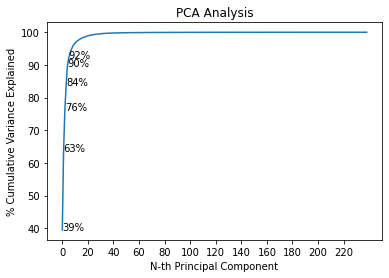

In [12]:
#Curva de porcentaje de varianza acumulada
total_components = df_pfeatures.shape[1]

pca = PCA()
pca_fit = pca.fit_transform(df_pfeatures)

plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.title('PCA Analysis')
plt.xlabel('N-th Principal Component')
plt.ylabel('% Cumulative Variance Explained')
plt.xticks(np.arange(0,total_components,20))

labels = np.cumsum(pca.explained_variance_ratio_)*100
for i in range(min(6, total_components)):
  plt.text(i,labels[i],str(format(labels[i],'.0f'))+'%')

In [13]:
# Se muestra la composición de los 20 componentes principales por cada una de las pFeatures
num_components = 20
pc_df = pd.DataFrame(abs(pca.components_[:num_components]), columns = df_pfeatures.columns, index=['Principal component {}'.format(i) for i in range(1, num_components + 1)])
pc_df

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,...,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y
Principal component 1,0.001829,0.000308,0.001521,0.001344,0.000043,4.463586e-04,2.137825e-04,0.000451,0.000308,0.001829,...,0.002517,0.005199,0.004721,0.003348,0.001976,0.006000,0.005613,0.003532,0.000376,0.003430
Principal component 2,0.001764,0.000489,0.002253,0.000223,0.002076,2.048152e-03,1.633187e-04,0.000006,0.000489,0.001764,...,0.002809,0.002732,0.000522,0.005194,0.009813,0.000543,0.000955,0.000051,0.001441,0.002879
Principal component 3,0.001078,0.000078,0.001000,0.000789,0.001652,1.430369e-03,4.079853e-04,0.000023,0.000078,0.001078,...,0.000903,0.002050,0.001937,0.000652,0.007164,0.002833,0.001334,0.004371,0.000267,0.002090
Principal component 4,0.000870,0.001326,0.000456,0.001112,0.000335,2.332795e-03,2.281623e-04,0.002444,0.001326,0.000870,...,0.000685,0.003095,0.002503,0.005243,0.006154,0.000508,0.001139,0.001807,0.007339,0.005896
Principal component 5,0.001196,0.001461,0.000266,0.002846,0.003835,3.524032e-03,1.282865e-03,0.000248,0.001461,0.001196,...,0.000424,0.008141,0.009865,0.004521,0.005164,0.004030,0.004323,0.002944,0.000224,0.007271
Principal component 6,0.000600,0.001267,0.000667,0.000138,0.000870,8.881236e-04,2.018792e-03,0.000003,0.001267,0.000600,...,0.007662,0.005024,0.013102,0.002638,0.000343,0.000854,0.000520,0.008165,0.004736,0.006239
Principal component 7,0.002161,0.002520,0.000359,0.003111,0.002807,3.656155e-03,2.087328e-03,0.001228,0.002520,0.002161,...,0.006944,0.005182,0.011124,0.003023,0.007467,0.002777,0.018726,0.004250,0.002636,0.008247
Principal component 8,0.001528,0.001180,0.000348,0.003207,0.003261,2.718193e-04,6.271877e-07,0.002255,0.001180,0.001528,...,0.009723,0.002772,0.000004,0.001104,0.003905,0.009747,0.017288,0.006320,0.006760,0.004157
Principal component 9,0.001951,0.001907,0.000044,0.000592,0.000471,3.207350e-03,3.280486e-03,0.002731,0.001907,0.001951,...,0.008818,0.008687,0.024225,0.011720,0.008669,0.003181,0.002002,0.002869,0.007731,0.007578
Principal component 10,0.001095,0.003127,0.002032,0.000787,0.000775,2.024910e-03,7.234727e-04,0.000372,0.003127,0.001095,...,0.013901,0.022853,0.007193,0.021482,0.005256,0.014184,0.004073,0.005843,0.007164,0.008616


In [14]:
# Se reducen los componentes principales a 20
pca_pfeatures = aplicar_pca(df_pfeatures)
pca_pfeatures.to_csv('../data/processed/DTCPep_pca_pfeatures.csv', index = False)
pca_pfeatures

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,7.501205,5.542866,-3.299727,-0.615858,-0.140809,-4.240089,0.054922,-1.103662,2.151382,-0.585718,0.185452,0.258664,1.791377,-0.934661,-0.444878,1.525542,1.102381,-1.453679
1,35.596961,1.253027,-3.290867,-1.917369,-1.675335,1.689235,-2.844695,-5.360342,4.129638,-3.558124,1.045723,0.682461,-0.313172,-1.522474,-0.260521,-0.366580,-2.199256,-2.064327
2,0.048692,-2.102665,4.266232,6.301210,0.347127,-1.140583,-0.529184,-1.192710,0.205464,-1.984166,-0.796590,0.604881,2.317820,-0.349833,0.181293,0.145816,-0.719761,0.499235
3,6.248013,-0.437229,-3.374583,-0.093313,-1.034880,-3.288081,-1.012011,-1.530326,-1.876773,0.320123,0.260471,0.527751,-1.655547,0.250641,1.620893,-0.382855,2.106894,-0.466087
4,17.817360,-11.520215,3.144051,14.541785,-3.205118,-0.674307,5.384155,0.198179,-0.228104,1.943457,1.605592,0.942199,1.754600,-1.139643,-2.243512,-0.839314,-1.537617,0.109125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086,-0.743904,11.165415,1.293731,-1.128877,4.574851,-0.163638,-0.756811,3.398156,-0.366152,0.567020,1.829488,1.173863,-0.174548,-1.107778,0.643257,-0.420434,0.360060,-0.083800
8087,-2.712124,3.076760,-6.062656,4.880931,2.678691,0.281154,-1.015585,0.980303,-0.980518,-0.416882,0.213860,0.505333,0.401540,0.262123,-0.023629,2.386107,-0.314615,0.958320
8088,11.935765,-6.113936,-4.597525,-1.801546,3.366693,-2.544619,-1.111349,-3.655741,-3.178647,-0.757042,1.566409,-0.446815,-0.086301,-0.035989,-1.834037,-0.705177,-0.085148,-1.599658
8089,0.535963,6.701618,-6.779012,-0.336857,0.220876,9.438734,-0.496692,-3.405901,-0.076173,3.449627,0.685524,-0.376731,-0.555681,-0.764419,0.854586,-0.709501,0.032339,0.064971


### Conclusiones
En la primera parte de esta actividad hicimos una ingeniería de características a las secuencias de aminoácidos de los péptidos, para depurar aquellos péptidos que contenían caracteres que podrían generar un sesgo al momento de que se haga el modelo predictivo. 

Posteriormente se utilizó la librería Pfeatures sobre las secuencias de aminoácidos ya depuradas, para obtener diferentes características fisicoquímicas. De estas a su vez se obtuvieron los 20 componentes principales que dan un valor arriba del 90% en la explicación de la varianza de las características.


### Referencias

1. INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY (IUPAC). https://iupac.qmul.ac.uk/AminoAcid/A2021.html#AA20
2. Fu, L., Niu, B., Zhu, Z., Wu, S., & Li, W. (2012). CD-HIT: accelerated for clustering the next-generation sequencing data. Bioinformatics (Oxford, England), 28(23), 3150–3152. https://doi.org/10.1093/bioinformatics/bts565
3. Raghava, S. P. a. D. a. P. D. K. N. S. G. M. R. K. P. a. V. P. a. L. H. K. S. J. P. G. (n.d.). Pfeature: A web server for computing protein and peptide features. https://webs.iiitd.edu.in/raghava/pfeature/
4. Dubchak I, et al. Proceedings of the National Academy of Sciences of the United States of America